# Résolution de l'EDP de Burgers

On souhaite résoudre l’EDP de Burgers paramétrique visqueuse déterminée par la formule suivante:

$$
\partial_t u + \partial_x \left( \frac{u^2}{2} \right) - \epsilon \partial_{xx} u = 0, \quad x \in [0, 1]
$$

Avec les conditions initiales et aux bords:

$$
 u(0, x) = u_0(x), \quad x \in [-1, 1]
$$
$$
 u(t, -1) = u(t, 1) = 0, \quad t > 0
$$

Où $\epsilon \in [0.02, 0.2]$ est le coefficient de viscosité.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


In [2]:
class Mesh:
    def __init__(self, a, b, N):
        self.a = a
        self.b = b
        self.N = N
        self.dx = (b-a)/N
        self.centers = np.linspace(a + self.dx/2, b - self.dx/2, N)
        self.interfaces = np.linspace(a, b, N+1)


In [3]:
#Phyical
epsilon = np.random.uniform(0.02,0.20)
#Domain 
a = 0
b = 1
N = 400
dx = (b - a) / N
mesh = Mesh(a,b,N)

## Time
T = 0.2
lambda_ = 1.2 # for sinus 
dt =  min(0.5*dx**2/ epsilon, dx/lambda_) *0.5
nSteps = int(T/dt)


def u0(x):
    return np.exp(-100*(x-0.5)**2)


#initiation
u = u0(mesh.centers)
resultMatrix = np.zeros([N,nSteps])
resultMatrix[:,0] = u

for i in range(1,nSteps):
    #numerique scheme base on project with Carl
    Ur = 0
    Ul = 0

    un = u.copy()   
    coeff= epsilon + dx/2*lambda_
    u[1:-1] = un[1:-1] -   0.25*dt / dx *(un[2:]**2 - un[:-2]**2) + coeff * dt / dx**2 *(un[2:] - 2 * un[1:-1] + un[:-2])

    # à droite de u[-1] on rajoute 0
    u[-1] = un[-1] -   0.25*dt / dx *(Ur**2 - un[-2]**2) + coeff * dt / dx**2 *(Ur - 2 * un[-1] + un[-2])
            
    #a gauche de u[0] on rajoute 0 
    u[0] = un[0] -   0.25*dt / dx *(un[2]**2 - Ul**2) + coeff * dt / dx**2 *(un[2] - 2 * un[1] +Ul)

    resultMatrix[:, i] = u

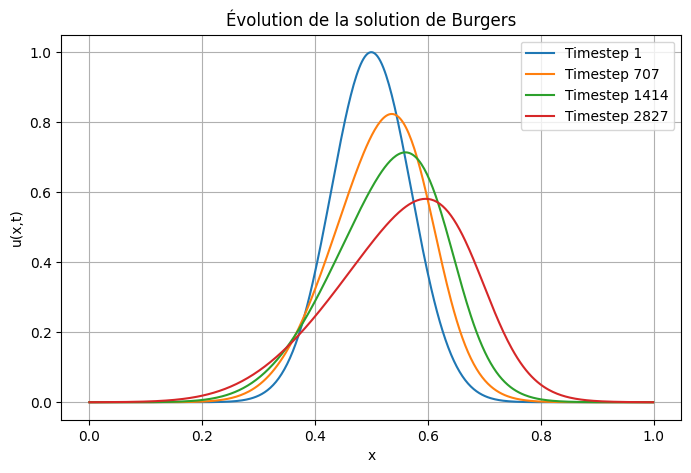

In [9]:
# Affichage des résultats
plt.figure(figsize=(8, 5))
time_steps = [1, nSteps//4, nSteps//2, nSteps - 1]
for t in time_steps:
    plt.plot(mesh.centers, resultMatrix[:, t], label=f'Timestep {t}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Évolution de la solution de Burgers')
plt.legend()
plt.grid()
plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim


target = torch.tensor(resultMatrix, dtype=torch.float32)
target = target.T.flatten().view(-1, 1)  # Vectorize to  (Nx * Nt, 1)


X_train = torch.tensor(mesh.centers, dtype=torch.float32).view(-1, 1)  # (Nx, 1)
T_train = torch.tensor(np.linspace(0, 0.2, nSteps), dtype=torch.float32).view(-1, 1)  # (Nt, 1)

# Create a Grid
X_grid, T_grid = torch.meshgrid(X_train.squeeze(), T_train.squeeze(), indexing="ij")
X_train_flat = X_grid.flatten().view(-1, 1)  # (Nx * Nt, 1)
T_train_flat = T_grid.flatten().view(-1, 1)  # (Nx * Nt, 1)


X_train_flat.requires_grad = True
T_train_flat.requires_grad = True

print(f"X_train shape: {X_train_flat.shape}")  # (Nx * Nt, 1)
print(f"T_train shape: {T_train_flat.shape}")  # (Nx * Nt, 1)
print(f"Target shape: {target.shape}")  # (Nx * Nt, 1)


class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers1 = nn.Linear(2, 50)  
        self.layers2 = nn.Linear(50, 50)
        self.layers3 = nn.Linear(50, 50)
        self.layersf = nn.Linear(50, 1)
        
    def forward(self, x):
        a = torch.tanh(self.layers1(x))
        b = torch.tanh(self.layers2(a))
        c = torch.tanh(self.layers3(b))
        return self.layersf(c)

model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def u_PINN(x, t):
    inputs = torch.cat([x, t], dim=1) 
    return model(inputs)  

def loss_function(x, t, eps):
    u = u_PINN(x, t)  

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    f = u_t + u * u_x - eps * u_xx  
    loss = torch.mean(f**2)
    return loss


def optimize(epochs=20000, track=True):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)

    for i in range(epochs):
        optimizer.zero_grad()
        output = u_PINN(X_train_flat, T_train_flat)
        MSE_u = criterion(output, target)  
        
        loss = MSE_u  
        print(f"Epoch {i}, Loss: {loss.item()}")

        loss.backward()
        optimizer.step()


optimize(2000)

import matplotlib.pyplot as plt
import numpy as np

# Générer les prédictions sur la grille d'espace-temps
with torch.no_grad():
    U_pred = u_PINN(X_train_flat, T_train_flat).cpu().numpy()  # Convertir en numpy

# Reshape pour retrouver la structure (Nx, Nt)
Nx = X_train.shape[0]  # Nombre de points en x
Nt = T_train.shape[0]  # Nombre de points en t
U_pred = U_pred.reshape(Nx, Nt)



X_train shape: torch.Size([1131200, 1])
T_train shape: torch.Size([1131200, 1])
Target shape: torch.Size([1131200, 1])
Epoch 0, Loss: 0.1152448058128357
Epoch 1, Loss: 0.10617288202047348
Epoch 2, Loss: 0.09799396991729736
Epoch 3, Loss: 0.09070739150047302
Epoch 4, Loss: 0.0843033641576767
Epoch 5, Loss: 0.0787639245390892
Epoch 6, Loss: 0.07406414300203323
Epoch 7, Loss: 0.07017283141613007
Epoch 8, Loss: 0.06705215573310852
Epoch 9, Loss: 0.06465645879507065
Epoch 10, Loss: 0.0629306510090828
Epoch 11, Loss: 0.06180881708860397
Epoch 12, Loss: 0.0612131804227829
Epoch 13, Loss: 0.06105414777994156
Epoch 14, Loss: 0.061231933534145355
Epoch 15, Loss: 0.06164051592350006
Epoch 16, Loss: 0.062173888087272644
Epoch 17, Loss: 0.06273418664932251
Epoch 18, Loss: 0.06323974579572678
Epoch 19, Loss: 0.06363100558519363
Epoch 20, Loss: 0.06387291103601456
Epoch 21, Loss: 0.06395378708839417
Epoch 22, Loss: 0.0638815313577652
Epoch 23, Loss: 0.06367846578359604
Epoch 24, Loss: 0.0633758679032

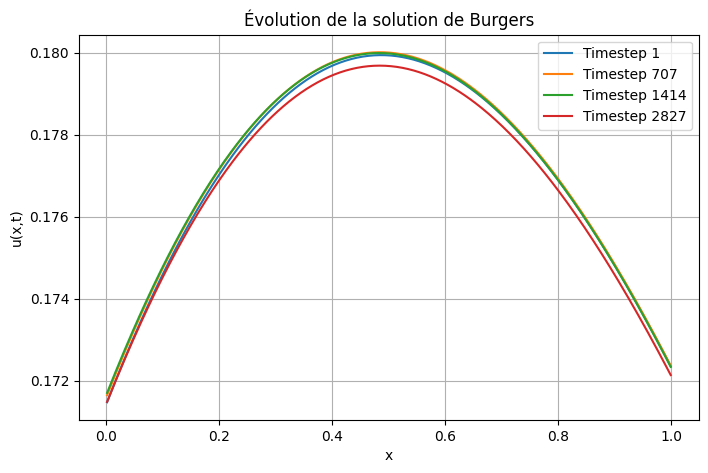

In [13]:
# Affichage des résultats
plt.figure(figsize=(8, 5))
time_steps = [1, nSteps//4, nSteps//2, nSteps - 1]
for t in time_steps:
    plt.plot(mesh.centers, U_pred[:, t], label=f'Timestep {t}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Évolution de la solution de Burgers')
plt.legend()
plt.grid()
plt.show()